In [19]:
# For now, clear outputs (Cell > All Output > Clear) before committing to Git
# There might be a better way

import sqlite3
import pandas as pd
cnx = sqlite3.connect('FPA_FOD_20170508.sqlite')

import matplotlib.pyplot as plt
import numpy as np

from sklearn import tree, preprocessing
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_sql_query("SELECT FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE FROM 'Fires'", cnx)
print(df.head())

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

   FIRE_SIZE  
0       0.10  
1       0.25  
2       0.10  
3       0.10  
4       0.10  


In [3]:
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
print(df.head())

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

   FIRE_SIZE       DATE  
0       0.10 2005-02-02  
1       0.25 2004-05-12  
2       0.10 2004-05-31  
3       0.10 2004-06-28  
4       0.10 2004-06-28  


In [4]:
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
df['DAY_OF_WEEK'] = df['DATE'].dt.weekday_name
df_orig = df.copy() #I will use this copy later
print(df.head())

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

   FIRE_SIZE       DATE  MONTH DAY_OF_WEEK  
0       0.10 2005-02-02      2   Wednesday  
1       0.25 2004-05-12      5   Wednesday  
2       0.10 2004-05-31      5      Monday  
3       0.10 2004-06-28      6      Monday  
4       0.10 2004-06-28      6      Monday  


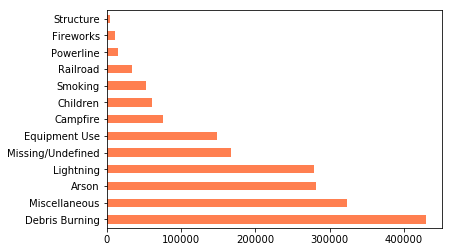

In [10]:
df['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral')
plt.show()

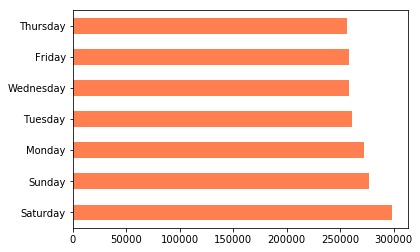

In [12]:
df['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

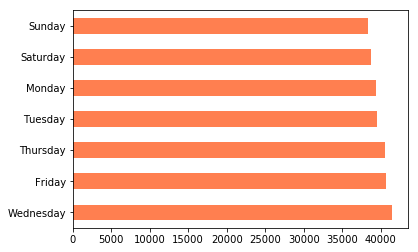

In [13]:
df_lightning = df[df['STAT_CAUSE_DESCR']=='Lightning']
df_lightning['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

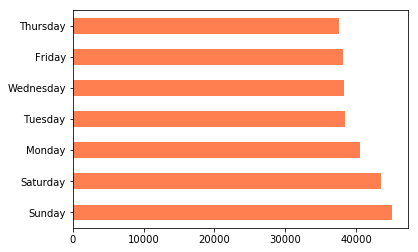

In [14]:
df_arson = df[df['STAT_CAUSE_DESCR']=='Arson']
df_arson['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

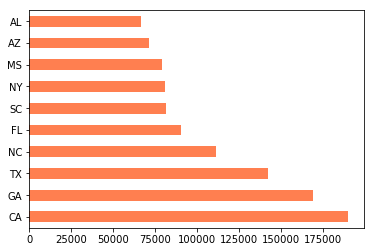

In [15]:
df['STATE'].value_counts().head(n=10).plot(kind='barh',color='coral')
plt.show()

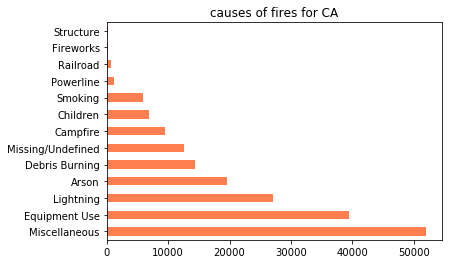

In [16]:
df_CA = df[df['STATE']=='CA']
df_CA['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral',title='causes of fires for CA')
plt.show()

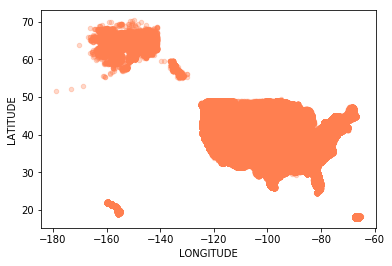

In [17]:
df.plot(kind='scatter',x='LONGITUDE',y='LATITUDE',color='coral',alpha=0.3)
plt.show()

In [20]:
le = preprocessing.LabelEncoder()
df['STAT_CAUSE_DESCR'] = le.fit_transform(df['STAT_CAUSE_DESCR'])
df['STATE'] = le.fit_transform(df['STATE'])
df['DAY_OF_WEEK'] = le.fit_transform(df['DAY_OF_WEEK'])
print(df.head())

   FIRE_YEAR  STAT_CAUSE_DESCR   LATITUDE   LONGITUDE  STATE  DISCOVERY_DATE  \
0       2005                 7  40.036944 -121.005833      4       2453403.5   
1       2004                 6  38.933056 -120.404444      4       2453137.5   
2       2004                 3  38.984167 -120.735556      4       2453156.5   
3       2004                 6  38.559167 -119.913333      4       2453184.5   
4       2004                 6  38.559167 -119.933056      4       2453184.5   

   FIRE_SIZE       DATE  MONTH  DAY_OF_WEEK  
0       0.10 2005-02-02      2            6  
1       0.25 2004-05-12      5            6  
2       0.10 2004-05-31      5            1  
3       0.10 2004-06-28      6            1  
4       0.10 2004-06-28      6            1  


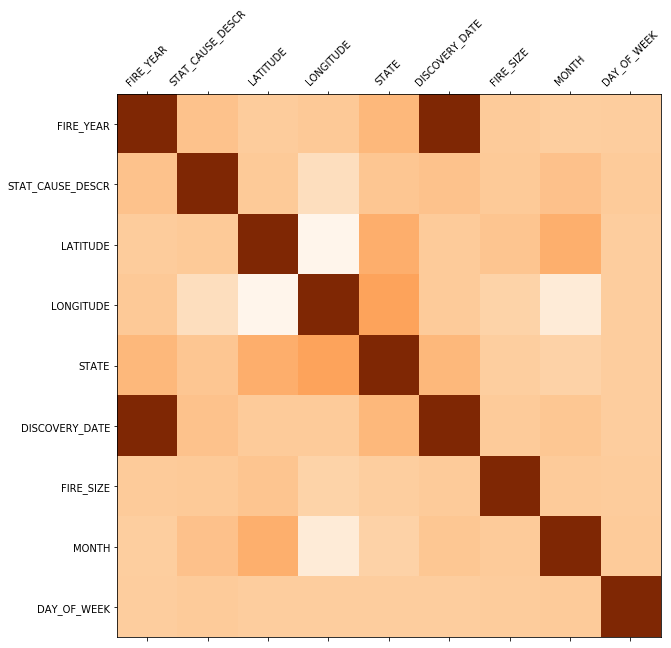

In [21]:
def plot_corr(df,size=10):
    corr = df.corr()  #the default method is pearson
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr,cmap=plt.cm.Oranges)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)    
    plt.show()
    

    
plot_corr(df)